# Tutorial: Nonlinear relativistic case, acceleration

### First import all classes necessary for simulation

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, m_e, e, epsilon_0, hbar

# Main classes for simulation, plasma, driver field and species
from qsa_pwfa.simulation import Simulation
from qsa_pwfa.species import NeutralUniformPlasma
from qsa_pwfa.external_fields import GaussianBunchField
from qsa_pwfa.species import GaussianBunch

# Diagnostics
from qsa_pwfa.diagnostics import FieldDiagnostics
from qsa_pwfa.diagnostics import BunchDiagnostics
from qsa_pwfa.diagnostics import SpeciesDiagnostics

### Code space and time units are normalized to plasma $k_p^{-1}$, $\omega_p^{-1}$. For this example let us consider input in SI units corresponding to plasma density $2\cdot 10^{18}$ cm$^{-3}$.

In [2]:
n_plasma = 2e18 * 1e6
k_p_inv = (e**2 / m_e /  c**2  / epsilon_0 * n_plasma)**-0.5
field_dim = c**2 * m_e / e / k_p_inv

### Let us define a driver and witness beams

In [3]:
Q_drv = 200e-12 # Beam charge in [C]

sigma_R_drv = 2e-6 / k_p_inv
sigma_Xi_drv = 2e-6 / k_p_inv
n_drv = Q_drv / e / (2*np.pi)**1.5 / (k_p_inv*sigma_R_drv)**2 / (k_p_inv*sigma_Xi_drv) / n_plasma 

Q_trl = 10e-12 # Beam charge in [C]
sigma_R_trl = 0.5e-6 / k_p_inv
sigma_Xi_trl = 0.3e-6 / k_p_inv
n_trl = Q_trl / e / (2*np.pi)**1.5 / (k_p_inv*sigma_R_trl)**2 / (k_p_inv*sigma_Xi_trl) / n_plasma 

gamma_trl = 200/0.511
delta_gamma_rel = 0.005
delta_theta = 6e-3

dt_trl = 2 * np.pi * (2 * gamma_trl)**.5 / 32

N_steps = 8

### and uniform plasma with a longitudinal and transverse sizes of 3 plasma waves

In [4]:
# plasma
L_xi = 3 * (2*np.pi)
L_r =  1 * (2*np.pi)

# grid
N_xi = 512 * 2
N_r = 512

d_xi = L_xi / N_xi
dr = L_r / N_r

In [5]:
driver_bunch = GaussianBunchField(n_drv, sigma_R_drv, sigma_Xi_drv)


##### Refining plasma ###
plasma = NeutralUniformPlasma(L_r=L_r, N_r=N_r)
r1 = 3e-6 / k_p_inv
r2 = 4e-6 / k_p_inv
N_r_hires = N_r

r_grid = plasma.r0.copy() 
r_grid_below = r_grid[r_grid<=r1]
r_grid_above = r_grid[r_grid>=r2]
r_grid_middle = np.r_[r_grid_below[-1] : r_grid_above[0] : N_r_hires*1j]

r_grid_user = np.r_[
    r_grid_below[:-1],
    r_grid_middle,
    r_grid_above[1:] 
]

plasma = NeutralUniformPlasma(r_grid_user=r_grid_user)

##### Refining Xi ###
sim = Simulation(L_xi=L_xi, N_xi=N_xi)
xi_0_trl = driver_bunch.xi_0 + 2 * np.pi - 1.
xi1 = xi_0_trl - 6*sigma_Xi_trl
xi2 = xi_0_trl + 6*sigma_Xi_trl
N_xi_hires = N_xi//2

xi_grid = sim.xi.copy()
xi_grid_before = xi_grid[xi_grid<=xi1]
xi_grid_after = xi_grid[xi_grid>=xi2]
xi_grid_middle = np.r_[xi_grid_before[-1] : xi_grid_after[0] : N_xi_hires*1j]
xi_grid_user = np.r_[
    xi_grid_before[:-1],
    xi_grid_middle,
    xi_grid_after[1:] 
]

sim = Simulation(xi_grid_user=xi_grid_user, dt=dt_trl*N_steps)

### Now lets setup and run the simulation

In [6]:
witness_bunch = GaussianBunch(sim, n_trl, sigma_R_trl, sigma_Xi_trl, 
                              xi_0=xi_0_trl, gamma_b=gamma_trl,
                              delta_gamma=delta_gamma_rel*gamma_trl,
                              eps_r=delta_theta*gamma_trl*sigma_R_trl,
                              n_cycles=N_steps
                             )

sim.add_specie( plasma )
sim.add_specie( witness_bunch )
sim.add_external_field( driver_bunch )

sim.diagnostics = [ 
    FieldDiagnostics( sim, L_r=L_r, N_r=N_r,
                      fields=['Density', ], 
                      xi_step=2 ),
    BunchDiagnostics( sim, witness_bunch, 
                      fields=['p_z','p_r'],
                      xi_step=1 )
]

sim.run_step()

  0%|          | 0/1482 [00:00<?, ?it/s]

reached max PC iterations at i_xi=0 (xi=0.0), with an error 0.0140128
reached max PC iterations at i_xi=889 (xi=7.9337486349445365), with an error 0.0110857
reached max PC iterations at i_xi=890 (xi=7.9521564043991635), with an error 0.014409
reached max PC iterations at i_xi=891 (xi=7.970564173853791), with an error 0.0438194
reached max PC iterations at i_xi=892 (xi=7.988971943308419), with an error 0.025189
reached max PC iterations at i_xi=1223 (xi=14.081943632790185), with an error 0.00974825
Specie 0 had 0.384679% violated QSA


### Now we plot the electron density

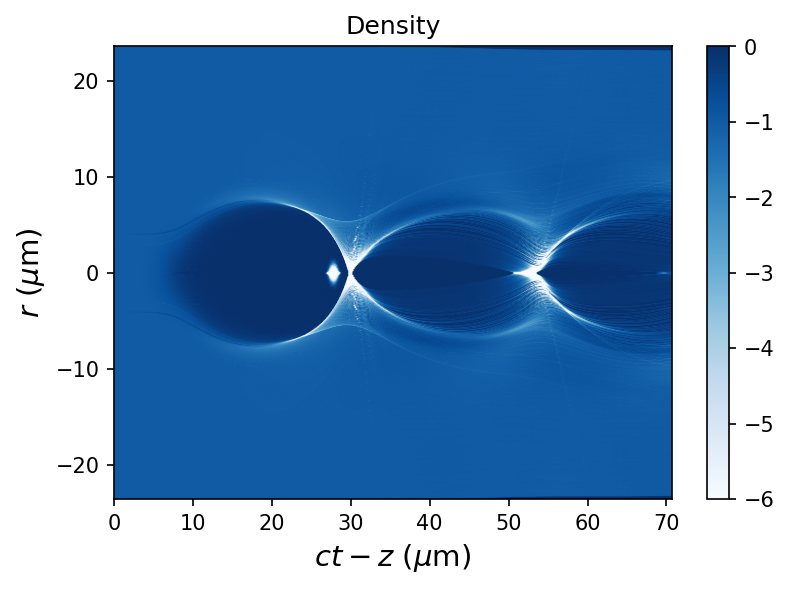

In [7]:
diag = sim.diagnostics[0]
ext = np.array([ diag.xi.min(),
                 diag.xi.max(),
                -diag.grid.rmax,
                 diag.grid.rmax ]) * k_p_inv * 1e6

for fld in diag.fields: 
    for i_t, outout in enumerate(diag.outputs):
        val = outout[fld]
        val_ext = np.hstack((val[:,1:][:,::-1], val[:,1:]))
        r_grid = np.hstack((-diag.grid.r0[1:][::-1], diag.grid.r0[1:]))
        
        plt.figure(dpi=150)

        vmin = -6
        plt.pcolormesh(diag.xi * k_p_inv* 1e6, 
                       r_grid * k_p_inv * 1e6, 
                       val_ext.T,
                       cmap=plt.cm.Blues,
                       vmax=0,
                       vmin=vmin,
                       shading='gouraud' )

        plt.colorbar()
        plt.xlabel(r'$ct-z$ ($\mu$m)', fontsize=14)
        plt.ylabel(r'$r$ ($\mu$m)', fontsize=14)
        plt.title(f"{fld}")

In [25]:
sim.diagnostics[-1].bunch.r0.shape, outout['r'].shape

((512,), (336, 512))

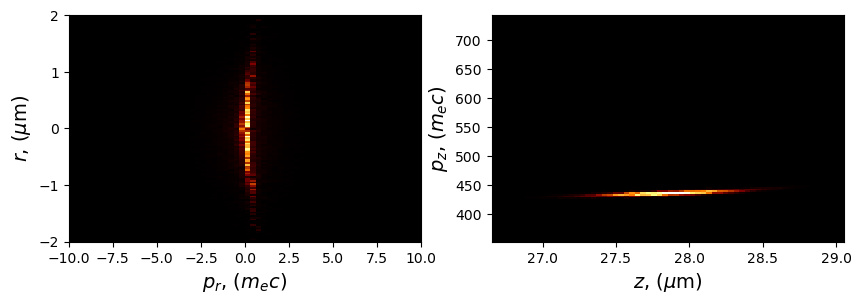

In [30]:
dr_trl = 2 * dr 

for outout in np.array(sim.diagnostics[-1].outputs):
    
    r0 = sim.diagnostics[-1].bunch.r0[None, :]

    z, pz = outout['xi'].flatten(), \
        outout['p_z'].flatten()
    r, pr, w = outout['r'].flatten(), \
        outout['p_r'].flatten(), \
        outout['dQ']
    
    w /= r0
    w = w.flatten()
    
    #r_round = dr_trl * np.ceil(r / dr_trl)
    r  *= np.sign(np.random.rand(r.size)-0.5)

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,3), dpi=100)
    ax1.hist2d(pr, r * k_p_inv* 1e6, weights=w, bins=(64, 128),
               range=[[-10.,10],
                      [-sim.diagnostics[-1].bunch.rmax * k_p_inv* 1e6, 
                       sim.diagnostics[-1].bunch.rmax * k_p_inv* 1e6],
                     ],
               cmap=plt.cm.afmhot_r );
    ax1.set_ylabel(r'$r$, ($\mu$m)', size=14)
    ax1.set_xlabel(r'$p_r$, ($m_e c$)', size=14)
    
    z_range = np.array([witness_bunch.xi_0 - 4*sigma_Xi_trl, 
                        witness_bunch.xi_0 + 4*sigma_Xi_trl]) * k_p_inv* 1e6
        
    ax2.hist2d(z * k_p_inv* 1e6, pz, weights=w, bins=(64, 128),
               range=[z_range, [0.9*gamma_trl, 1.9*gamma_trl]],
               cmap=plt.cm.afmhot_r );
    ax2.set_xlabel(r'$z$, ($\mu$m)', size=14)
    ax2.set_ylabel(r'$p_z$, ($m_e c$)', size=14)

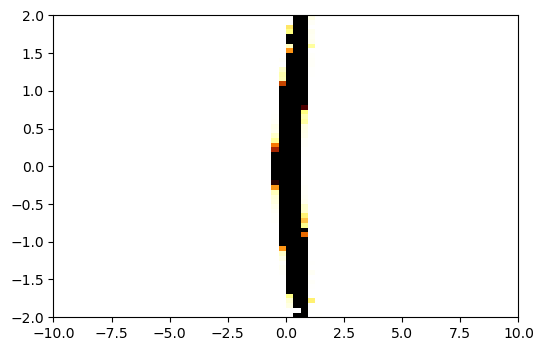

In [42]:
dr_trl = 2 * dr 

for outout in np.array(sim.diagnostics[-1].outputs):

    r0 = sim.diagnostics[-1].bunch.r0[None, :]
    r, pr, w = outout['r'].flatten(), \
        outout['p_r'].flatten(), \
        outout['dQ']
    
    w /= r0
    w = w.flatten()
    r  *= np.sign(np.random.rand(r.size)-0.5)

    fig = plt.figure(dpi=100)
    plt.hist2d(pr, r * k_p_inv* 1e6, weights=-w, bins=(64, 64),
               range=[[-10.,10],
                      [-sim.diagnostics[-1].bunch.rmax * k_p_inv* 1e6, 
                       sim.diagnostics[-1].bunch.rmax * k_p_inv* 1e6],],
               cmap=plt.cm.afmhot_r ,
               vmax=1e20,
              );
    #ax1.set_ylabel(r'$r$, ($\mu$m)', size=14)
    #ax1.set_xlabel(r'$p_r$, ($m_e c$)', size=14)
    #plt.ylim(-2,2)